<a href="https://colab.research.google.com/github/Wee7/FinancialEngineering_IR_xVA/blob/main/FE_xVA_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 02- Understanding of Filtrations and Measures

[4.440892098500626e-16, -1.3877787807814457e-17, 0.0, 0.0, 0.0, -2.220446049250313e-16, 0.0, -8.881784197001252e-16, -8.881784197001252e-16, 0.0, 0.0, 0.0, 0.0, 0.0, -4.440892098500626e-16, 0.0, 0.0, 0.0, 0.0, -2.220446049250313e-16, -2.220446049250313e-16, 2.0816681711721685e-17, 0.0, 2.220446049250313e-16, 0.0, -5.551115123125783e-17, 0.0, 0.0, -6.245004513516506e-17, -1.1102230246251565e-16, -4.440892098500626e-16, 0.0, 0.0, 2.220446049250313e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251565e-16, -4.440892098500626e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.1102230246251565e-16, -4.440892098500626e-16, 0.0, 0.0, 2.220446049250313e-16, 2.7755575615628914e-17, 0.0, 0.0, 0.0, -1.1102230246251565e-16, 0.0, 4.85722573273506e-17, 8.881784197001252e-16, 0.0, 0.0, -1.1102230246251565e-16, -2.220446049250313e-16, 0.0, -1.1102230246251565e-16, 0.0, 5.551115123125783e-17, 0.0, 0.0, 0.0, 0.0, 5.551115123125783e-17, 2.220446049250313e-16, 0.0, 0.0, 4.440892098500626e-16, -1.1102230

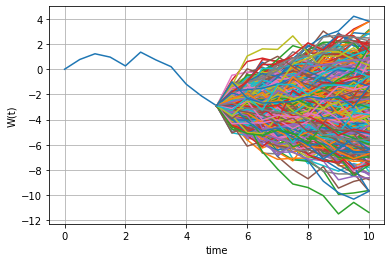

In [ ]:
#%% Martingale.py
"""
Created on July 05  2021
Simulation of, E(W(t)|F(s)) = W(s) using nested Monte Carlo

This code is purely educational and comes from "Financial Engineering" course by L.A. Grzelak
The course is based on the book â€œMathematical Modeling and Computation
in Finance: With Exercises and Python and MATLAB Computer Codesâ€,
by C.W. Oosterlee and L.A. Grzelak, World Scientific Publishing Europe Ltd, 2019.
@author: Lech A. Grzelak
"""
import numpy as np
import matplotlib.pyplot as plt
t = 10 
s = 5
NoOfPaths=1000
NoOfSteps=10

# First part to caclulate E(W(t)|F(0)) = W(0)=0
def martingaleA():
    W_t = np.random.normal(0.0,pow(t,0.5),[NoOfPaths,1])
    E_W_t = np.mean(W_t)
    print("mean value equals to: %.2f while the expected value is W(0) =%0.2f " %(E_W_t,0.0))
    
# Second part requiring nested Monte Carlo simulation  E(W(t)|F(s)) = W(s)
def martingaleB():    
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W = np.zeros([NoOfPaths,NoOfSteps+1])
        
    # time-step from [t0,s]
    dt1 = s / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
        W[:,i+1] = W[:,i] + pow(dt1,0.5)*Z[:,i]
            
    #W_s is the last column of W
    W_s = W[:,-1]
    #for every path W(s) we perform sub-simulation until time t and calculate
    #the expectation
    # time-step from [s,t]
    dt2     = (t-s)/float(NoOfSteps);
    W_t     = np.zeros([NoOfPaths,NoOfSteps+1]);
    
    #Store the results
    E_W_t = np.zeros([NoOfPaths])
    Error=[]
    for i in range(0,NoOfPaths):
        #Sub-simulation from time "s" until "t"
        W_t[:,0] = W_s[i];
        Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
        for j in range(0,NoOfSteps):
            #this is a scaling that ensures that Z has mean 0 and variance 1
            Z[:,j] = (Z[:,j]-np.mean(Z[:,j])) / np.std(Z[:,j]);
            #path simulation, from "s" until "t"
            W_t[:,j+1] = W_t[:,j] + pow(dt2,0.5)*Z[:,j];        
            
        E_W_t[i]=np.mean(W_t[:,-1])
        Error.append(E_W_t[i]-W_s[i])
        
        #Generate a plot for the first path
        if i==0:
            plt.plot(np.linspace(0,s,NoOfSteps+1),W[0,:])
            for j in range(0,NoOfPaths):
                plt.plot(np.linspace(s,t,NoOfSteps+1),W_t[j,:])
            plt.xlabel("time")
            plt.ylabel("W(t)")
            plt.grid()
        
    print(Error)
    error = np.max(np.abs(E_W_t-W_s))
    print("The error is equal to: %.18f"%(error))
    
martingaleB()
    

100
1100
2100
3100
4100
5100
6100
7100
8100
9100


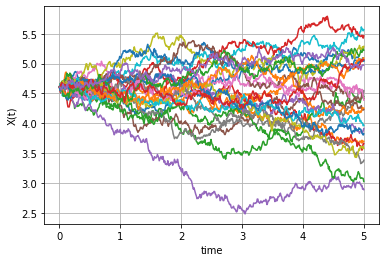

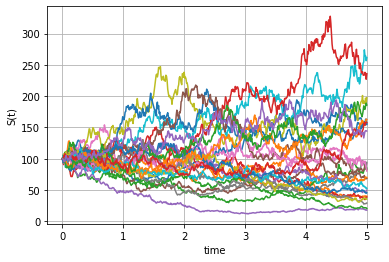

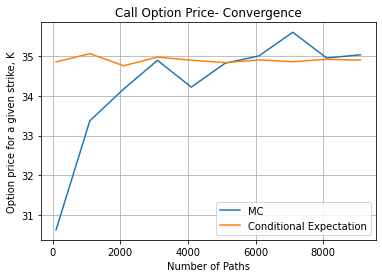

In [ ]:
#%% Black_Scholes_Jumps.py
"""
Created on July 05  2021
Impact of conditional expectation pricing (Black-Scholes with Jump volatility)

This code is purely educational and comes from "Financial Engineering" course by L.A. Grzelak
The course is based on the book â€œMathematical Modeling and Computation
in Finance: With Exercises and Python and MATLAB Computer Codesâ€,
by C.W. Oosterlee and L.A. Grzelak, World Scientific Publishing Europe Ltd, 2019.
@author: Lech A. Grzelak
"""
import numpy as np
import matplotlib.pyplot as plt
import enum
import scipy.stats as st

# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0
    
def GeneratePaths(NoOfPaths,NoOfSteps,S0,T,muJ,sigmaJ,r):    
    # Create empty matrices for Poisson process and for compensated Poisson process
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    S = np.zeros([NoOfPaths, NoOfSteps+1])
    time = np.zeros([NoOfSteps+1])
                
    dt = T / float(NoOfSteps)
    X[:,0] = np.log(S0)
    S[:,0] = S0
    
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    J = np.random.normal(muJ,sigmaJ,[NoOfPaths,NoOfSteps])
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
            
        X[:,i+1]  = X[:,i] + (r - 0.5*J[:,i]**2.0)*dt +J[:,i]*np.sqrt(dt)* Z[:,i]
        time[i+1] = time[i] +dt
        
    S = np.exp(X)
    paths = {"time":time,"X":X,"S":S,"J":J}
    return paths

def EUOptionPriceFromMCPaths(CP,S,K,T,r):
    # S is a vector of Monte Carlo samples at T
    if CP == OptionType.CALL:
        return np.exp(-r*T)*np.mean(np.maximum(S-K,0.0))
    elif CP == OptionType.PUT:
        return np.exp(-r*T)*np.mean(np.maximum(K-S,0.0))

def BS_Call_Put_Option_Price(CP,S_0,K,sigma,t,T,r):
    K = np.array(K).reshape([len(K),1])
    d1 = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0))
    * (T-t)) / (sigma * np.sqrt(T-t))
    d2 = d1 - sigma * np.sqrt(T-t)
    if CP == OptionType.CALL:
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * (T-t))
    elif CP == OptionType.PUT:
        value = st.norm.cdf(-d2) * K * np.exp(-r * (T-t)) - st.norm.cdf(-d1)*S_0
    return value

def CallOption_CondExpectation(NoOfPaths,T,S0,K,J,r):
    
    # Jumps at time T
    J_i = J[:,-1]
    
    result = np.zeros([NoOfPaths])
    
    for j in range(0,NoOfPaths):
        sigma = J_i[j]
        result[j] = BS_Call_Put_Option_Price(OptionType.CALL,S0,[K],sigma,0.0,T,r)
        
    return np.mean(result)

def mainCalculation():
    NoOfPaths = 25
    NoOfSteps = 500
    T = 5
    muJ = 0.3
    sigmaJ = 0.005
    
    S0 =100
    r  =0.00
    Paths = GeneratePaths(NoOfPaths,NoOfSteps,S0, T,muJ,sigmaJ,r)
    timeGrid = Paths["time"]
    X = Paths["X"]
    S = Paths["S"]
           
    plt.figure(1)
    plt.plot(timeGrid, np.transpose(X))   
    plt.grid()
    plt.xlabel("time")
    plt.ylabel("X(t)")
    
    plt.figure(2)
    plt.plot(timeGrid, np.transpose(S))   
    plt.grid()
    plt.xlabel("time")
    plt.ylabel("S(t)")
    
    # Check the convergence for a given strike
    K = 80
    CP =OptionType.CALL
    
    NGrid = range(100,10000,1000)
    NoOfRuns = len(NGrid)
    
    resultMC = np.zeros([NoOfRuns])
    resultCondExp = np.zeros([NoOfRuns])
       
    for (i,N) in enumerate(NGrid):
            print(N)
            Paths = GeneratePaths(N,NoOfSteps,S0, T,muJ,sigmaJ,r)
            timeGrid = Paths["time"]
            S = Paths["S"]
            resultMC[i] = EUOptionPriceFromMCPaths(CP,S[:,-1],K,T,r)
            
            J = Paths["J"]

            resultCondExp[i]=CallOption_CondExpectation(NoOfPaths,T,S0,K,J,r)
    
    plt.figure(3)
    plt.plot(NGrid,resultMC)  
    plt.plot(NGrid,resultCondExp)
    plt.legend(['MC','Conditional Expectation'])
    plt.title('Call Option Price- Convergence')
    plt.xlabel('Number of Paths')
    plt.ylabel('Option price for a given strike, K')
    plt.grid()
                       
mainCalculation()